## Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa

## Define Dataset Library

In [2]:
import pathlib
data_dir = pathlib.Path(r"C:\Users\İrem\Desktop\Project\dataset")
data_dir

WindowsPath('C:/Users/İrem/Desktop/Project/dataset')

## Count Number of Data

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

76


## Assign Benigns to List

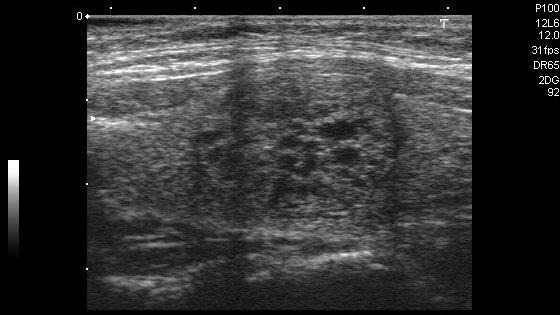

In [4]:
benigns = list(data_dir.glob('benign/*'))
PIL.Image.open(str(benigns[0]))

## Assign Maligns to List

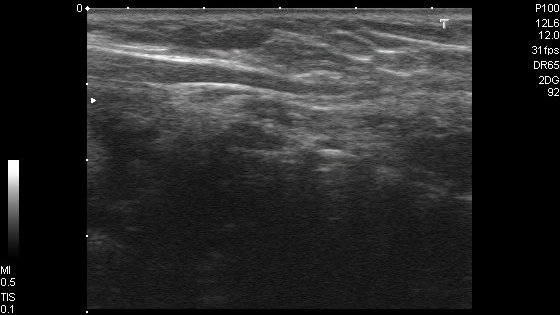

In [5]:
maligns = list(data_dir.glob('malign/*'))
PIL.Image.open(str(maligns[0]))

## Count Numbers of Each Label 

In [6]:
del benigns[14]
del maligns[62]
print("Number of Maligns : ",len(maligns))
print("Number of Benigns : ",len(benigns))

Number of Maligns :  62
Number of Benigns :  14


## Define Constants

In [7]:
batch_size = 32
img_height = 180
img_width = 180

## Create Training Set

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 76 files belonging to 2 classes.
Using 61 files for training.


## Create Validation Set

In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 76 files belonging to 2 classes.
Using 15 files for validation.


## Print Class Names

In [10]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malign']


## First 16 Images From Train Data

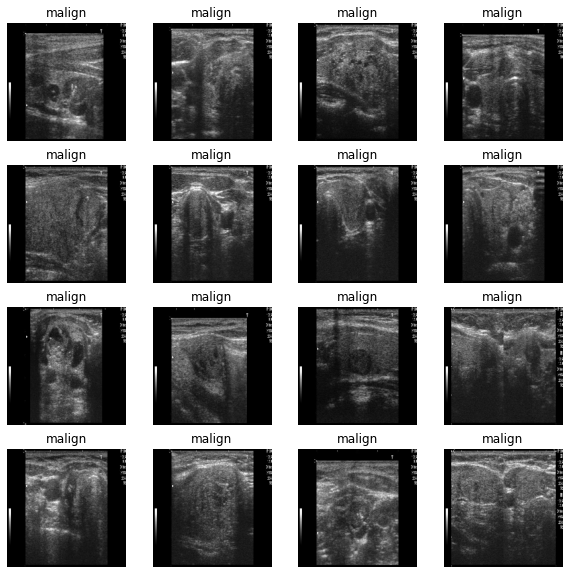

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

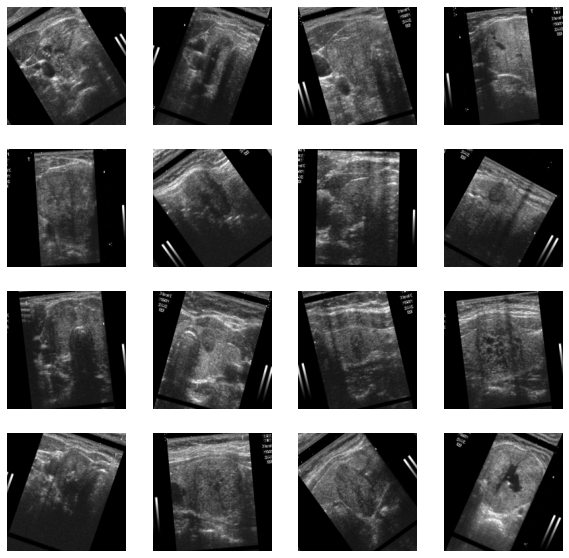

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    asd = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(asd[i].numpy().astype("uint8"))
    plt.axis("off")

## Add Flipped data to train_ds

In [14]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [15]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Image Batch and Labels Batch

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Data tuning

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize The Data

In [17]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Create The Model

In [19]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile The Model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

In [22]:
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Train The Model

In [23]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
2/2 [==============================] - 1s 515ms/step - loss: 1.0380 - accuracy: 0.7869 - val_loss: 0.2845 - val_accuracy: 0.9333
Epoch 2/20
2/2 [==============================] - 1s 362ms/step - loss: 0.6346 - accuracy: 0.7869 - val_loss: 0.5757 - val_accuracy: 0.9333
Epoch 3/20
2/2 [==============================] - 1s 345ms/step - loss: 0.5758 - accuracy: 0.8361 - val_loss: 0.5223 - val_accuracy: 0.9333
Epoch 4/20
2/2 [==============================] - 1s 359ms/step - loss: 0.5228 - accuracy: 0.8361 - val_loss: 0.3734 - val_accuracy: 0.9333
Epoch 5/20
2/2 [==============================] - 1s 307ms/step - loss: 0.4437 - accuracy: 0.7869 - val_loss: 0.2882 - val_accuracy: 0.9333
Epoch 6/20
2/2 [==============================] - 1s 301ms/step - loss: 0.4440 - accuracy: 0.7869 - val_loss: 0.2566 - val_accuracy: 0.9333
Epoch 7/20
2/2 [==============================] - 1s 304ms/step - loss: 0.4323 - accuracy: 0.7869 - val_loss: 0.2699 - val_accuracy: 0.9333
Epoch 8/20
2/2 [====

## Visualize Training Results

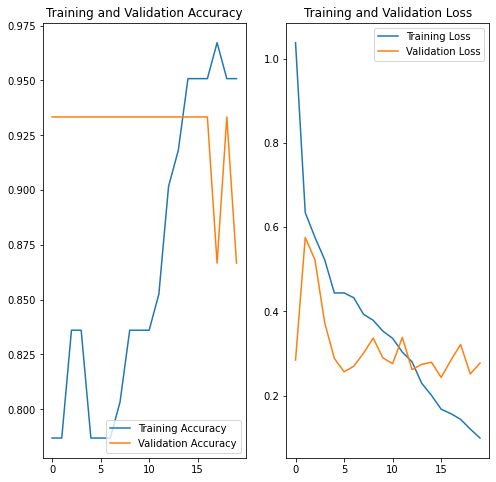

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on New Data

In [25]:
image_path='C:\\Users\\İrem\\Desktop\\Project\\dataset\\benign\\14.jpg'
img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to benign with a 96.93 percent confidence.
